# CovXY estimations for the basin

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
gpu_stream = cuda.Stream()

Basin utils

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *
from utils.BasinPlot import *

## Data Assimilation

In [6]:
ls = [6, 7, 8, 9, 10]

In [7]:
args_list = []

for l in ls:
    lvl_grid_args = initGridSpecs(l)
    args_list.append( {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        "gpu_ctx": gpu_ctx,
        "gpu_stream": gpu_stream,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
        } )

In [8]:
from utils.BasinParameters import *

In [9]:
data_args_list = []
for l_idx in range(len(args_list)): #TODO: Check indices 
    data_args_list.append( make_init_steady_state(args_list[l_idx], a=steady_state_bump_a, bump_fractal_dist=steady_state_bump_fractal_dist) )


In [10]:
obs_x, obs_y = obs_xs[0], obs_ys[0]

In [11]:
# obs_var = slice(0,1) # eta
obs_var = slice(1,3) # hu and hv
# obs_var = slice(0,3) # eta, hu, hv

In [12]:
if obs_var.step is None:
    obs_varN = (obs_var.stop - obs_var.start) 
else: 
    obs_varN = (obs_var.stop - obs_var.start)/obs_var.step

In [13]:
vlims = [[1, 0.25, 0.25],[1, 25, 25],[1, 25, 25]]

## Reference

In [14]:
from utils.BasinSL import *

In [15]:
SL_ensemble = initSLensemble(250, args_list[-1], data_args_list[-1], sample_args, init_model_error_basis_args, sim_model_error_basis_args, sim_model_error_timestep)

In [16]:
Hx, Hy = SLobsCoord2obsIdx(SL_ensemble, obs_x, obs_y)

In [17]:
SL_state = SLdownload(SL_ensemble)

In [18]:
X0 = SL_state
X0mean = np.average(X0, axis=-1)

Y0 = SL_state[obs_var,Hy,Hx] 
Y0mean = np.average(Y0, axis=-1)[:,np.newaxis]

SL_XY = (1/(len(SL_ensemble)-1)*((X0-X0mean[:,:,:,np.newaxis]).reshape(-1,X0.shape[-1]) @ (Y0 - Y0mean).T) ).reshape(X0mean.shape + (obs_varN,))

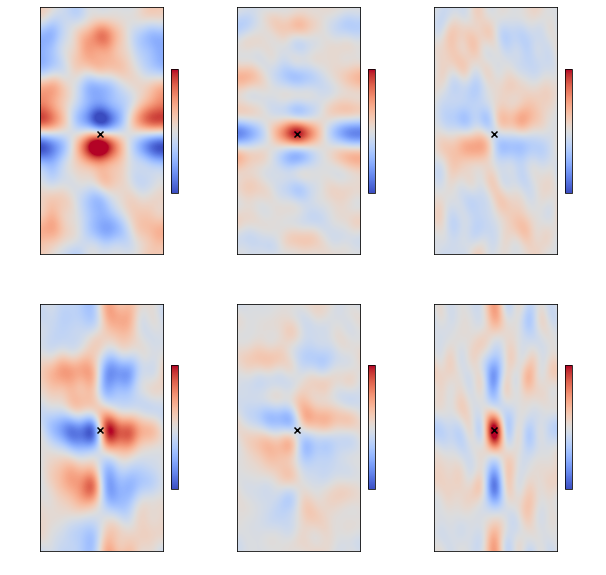

In [19]:
fig, axs = plt.subplots(obs_varN,3, figsize=(10,5*obs_varN))
for i in range(obs_var.start, obs_var.stop):
    for j in range(3):
        
        if obs_varN == 1:
            ax = axs[j]
        elif obs_varN > 1:
            ax = axs[i-obs_var.start,j]
            
        im = ax.imshow(SL_XY[j,:,:,i-obs_var.start], vmin=-vlims[j][i],vmax=vlims[j][i], cmap="coolwarm")
        ax.scatter(Hx, Hy, marker="x", c="black")
        plt.colorbar(im, ax=ax, shrink=0.5)

### Multi-level Ensemble

In [20]:
Nes = [100, 75, 50, 25, 10]

In [21]:
from utils.BasinEnsembleInit import *

ML_ensemble = initMLensemble(Nes, args_list, data_args_list, sample_args, init_model_error_basis_args, sim_model_error_basis_args, sim_model_error_timestep)

In [22]:
from gpuocean.ensembles import MultiLevelOceanEnsemble

MLOceanEnsemble = MultiLevelOceanEnsemble.MultiLevelOceanEnsemble(ML_ensemble)

### Covariances

Preparations

In [23]:
numLevels = len(ls)

In [24]:
ML_state = MLOceanEnsemble.download()

In [25]:
ML_prior = copy.deepcopy(ML_state)

In [26]:
lvl_X, lvl_Y = [], []
for l_idx in range(len(MLOceanEnsemble.Nes)):
    lvl_Xs = np.linspace(0.5*MLOceanEnsemble.dxs[l_idx], (MLOceanEnsemble.nxs[l_idx] - 0.5) * MLOceanEnsemble.dxs[l_idx], MLOceanEnsemble.nxs[l_idx])
    lvl_Ys = np.linspace(0.5*MLOceanEnsemble.dys[l_idx], (MLOceanEnsemble.nys[l_idx] - 0.5) * MLOceanEnsemble.dys[l_idx], MLOceanEnsemble.nys[l_idx])
    new_lvl_X, new_lvl_Y = np.meshgrid(lvl_Xs, lvl_Ys)
    lvl_X.append(new_lvl_X)
    lvl_Y.append(new_lvl_Y)

In [27]:
obs_idxs = [list(np.unravel_index(np.argmin((lvl_X[0] - obs_x)**2 + (lvl_Y[0] - obs_y)**2), ML_state[0][0].shape[:-1]))]
for l_idx in range(1, len(Nes)):
    obs_idxs0 = np.unravel_index(np.argmin((lvl_X[l_idx]   - obs_x)**2 + (lvl_Y[l_idx]   - obs_y)**2), ML_state[l_idx][0][0].shape[:-1])
    obs_idxs1 = np.unravel_index(np.argmin((lvl_X[l_idx-1] - obs_x)**2 + (lvl_Y[l_idx-1] - obs_y)**2), ML_state[l_idx][1][0].shape[:-1])
    obs_idxs.append([list(obs_idxs0), list(obs_idxs1)])


In [28]:
obs_idxs

[[62, 31],
 [[125, 62], [62, 31]],
 [[250, 125], [125, 62]],
 [[500, 250], [250, 125]],
 [[1000, 500], [500, 250]]]

Means

In [29]:
Xmean = MLOceanEnsemble.estimate(np.mean)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

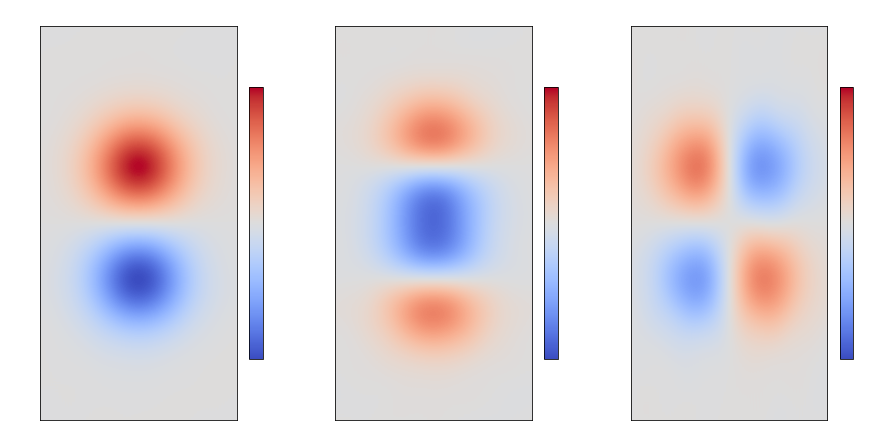

In [30]:
imshow3(Xmean)

In [31]:
Ymean = np.zeros(3)[obs_var]

Y0 = ML_state[0][obs_var,obs_idxs[0][0],obs_idxs[0][1]]
Ymean += np.average(Y0, axis=-1)

for l_idx in range(1,len(ls)):

    Y0 = ML_state[l_idx][0][obs_var,obs_idxs[l_idx][0][0],obs_idxs[l_idx][0][1]]
    Y1 = ML_state[l_idx][1][obs_var,obs_idxs[l_idx][1][0],obs_idxs[l_idx][1][1]]

    Ymean += np.average(Y0-Y1, axis=1)

In [32]:
Ymean

array([-86.3457457,  -0.5995356])

### Covariance

only coarse

In [57]:
ML_XY = np.zeros((np.prod(ML_state[-1][0].shape[:-1]),obs_varN))

In [58]:
X0 = ML_state[0]
X0mean = np.average(X0, axis=-1)

Y0 = ML_state[0][obs_var,obs_idxs[0][0],obs_idxs[0][1]]
Y0mean = np.average(Y0, axis=-1)[:,np.newaxis]

ML_XY += (1/Nes[0]*(
            (X0-X0mean[:,:,:,np.newaxis]).reshape(-1,Nes[0]) 
            @ (Y0 - Y0mean).T)
         ).reshape(X0mean.shape + (obs_varN,)).repeat(2**(numLevels-1),1).repeat(2**(numLevels-1),2).reshape(-1,obs_varN)

Text(0.5, 0.9, 'Kalman Gain')

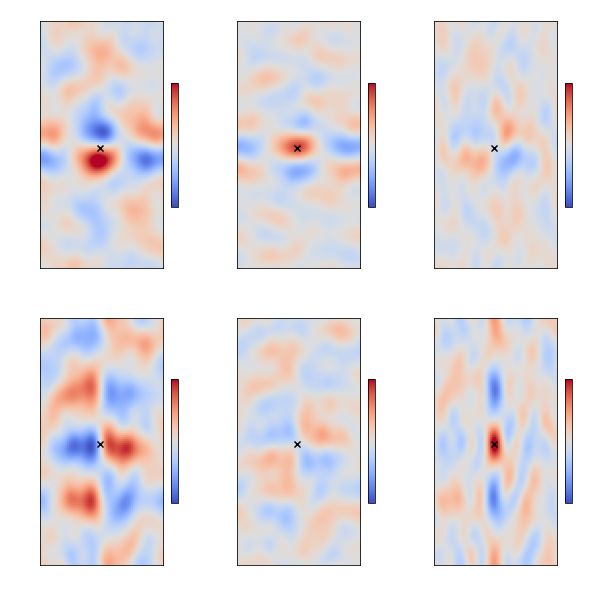

In [59]:
ML_XY_field = ML_XY.reshape(ML_state[-1][0].shape[:-1] + (obs_varN,))

fig, axs = plt.subplots(obs_varN,3, figsize=(10,5*obs_varN))
for i in range(obs_var.start, obs_var.stop):
    for j in range(3):
        
        if obs_varN == 1:
            ax = axs[j]
        elif obs_varN > 1:
            ax = axs[i-obs_var.start,j]
            
        im = ax.imshow(ML_XY_field[j,:,:,i-obs_var.start], vmin=-vlims[j][i],vmax=vlims[j][i], cmap="coolwarm")
        ax.scatter(Hx, Hy, marker="x", c="black")
        plt.colorbar(im, ax=ax, shrink=0.5)

fig.suptitle("Kalman Gain", y=0.9)

In [60]:
np.sqrt(np.sum((ML_XY_field - SL_XY)**2))

8215.773364244485

### Covariances

$\Sigma_{XY} = \mathbb{E}\left[ (X - \mathbb{E}[X]) (Y - \mathbb{E}[Y]) \right] $

and using ML-estimator only for outer expectation

In [36]:
ML_XY = np.zeros((np.prod(ML_state[-1][0].shape[:-1]),obs_varN))

In [37]:
X0 = ML_state[0]
X0mean = np.average(X0, axis=-1)

Y0 = ML_state[0][obs_var,obs_idxs[0][0],obs_idxs[0][1]]
Y0mean = np.average(Y0, axis=-1)[:,np.newaxis]

ML_XY += (1/Nes[0]*(
            (X0-X0mean[:,:,:,np.newaxis]).reshape(-1,Nes[0]) 
            @ (Y0 - Y0mean).T)
         ).reshape(X0mean.shape + (obs_varN,)).repeat(2**(numLevels-1),1).repeat(2**(numLevels-1),2).reshape(-1,obs_varN)

In [38]:
for l_idx in range(1,len(ls)):

    X0 = ML_state[l_idx][0]
    X0mean = np.average(X0, axis=-1)[:,:,:,np.newaxis]
    X1 = ML_state[l_idx][1].repeat(2,1).repeat(2,2)
    X1mean = np.average(X1, axis=-1)[:,:,:,np.newaxis]

    Y0 = ML_state[l_idx][0][obs_var,obs_idxs[l_idx][0][0],obs_idxs[l_idx][0][1]]
    Y0mean = np.average(Y0, axis=-1)[:,np.newaxis]
    Y1 = ML_state[l_idx][1][obs_var,obs_idxs[l_idx][1][0],obs_idxs[l_idx][1][1]]
    Y1mean = np.average(Y1, axis=-1)[:,np.newaxis]

    ML_XY += ( ( 1/Nes[l_idx]*(
                  (X0-X0mean).reshape(-1,Nes[l_idx]) @ (Y0 - Y0mean).T) 
                 - 1/Nes[l_idx]*(
                  (X1-X1mean).reshape(-1,Nes[l_idx]) @ (Y1 - Y1mean).T) 
                )
             ).reshape(X0.shape[:-1] + (obs_varN,)).repeat(2**(numLevels-l_idx-1),1).repeat(2**(numLevels-l_idx-1),2).reshape(-1,obs_varN)


Text(0.5, 0.9, 'Kalman Gain')

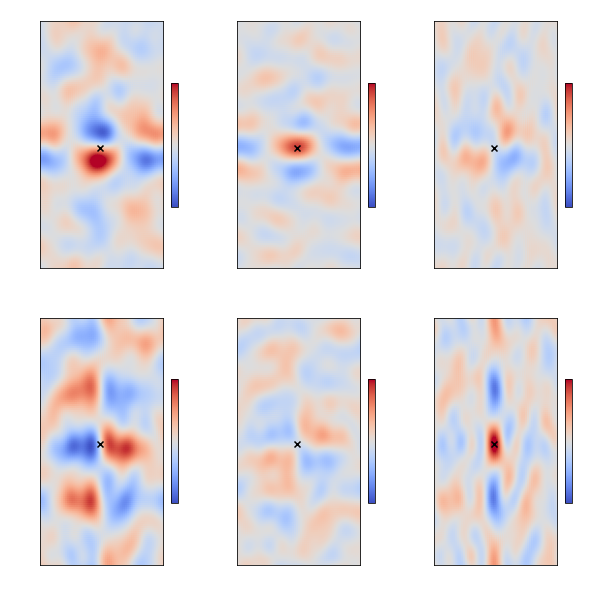

In [39]:
ML_XY_field = ML_XY.reshape(ML_state[-1][0].shape[:-1] + (obs_varN,))

fig, axs = plt.subplots(obs_varN,3, figsize=(10,5*obs_varN))
for i in range(obs_var.start, obs_var.stop):
    for j in range(3):
        
        if obs_varN == 1:
            ax = axs[j]
        elif obs_varN > 1:
            ax = axs[i-obs_var.start,j]
            
        im = ax.imshow(ML_XY_field[j,:,:,i-obs_var.start], vmin=-vlims[j][i],vmax=vlims[j][i], cmap="coolwarm")
        ax.scatter(Hx, Hy, marker="x", c="black")
        plt.colorbar(im, ax=ax, shrink=0.5)

fig.suptitle("Kalman Gain", y=0.9)

In [40]:
np.sqrt(np.sum((ML_XY_field - SL_XY)**2))

8241.706240453083

### Covariances

$\Sigma_{XY} = \mathbb{E}\left[ (X - \mathbb{E}[X]) (Y - \mathbb{E}[Y]) \right] $

and using ML-estimator for all expected values

In [41]:
ML_XY = np.zeros((np.prod(ML_state[-1][0].shape[:-1]),obs_varN))

In [42]:
X0 = ML_state[0]
X0mean = block_reduce(Xmean, func=np.mean, block_size=(1,2**(numLevels-1), 2**(numLevels-1)))

Y0 = ML_state[0][obs_var,obs_idxs[0][0],obs_idxs[0][1]]
Y0mean = Ymean[:,np.newaxis]

ML_XY += (1/Nes[0]*(
            (X0-X0mean[:,:,:,np.newaxis]).reshape(-1,Nes[0]) 
            @ (Y0 - Y0mean).T)
         ).reshape(X0mean.shape + (obs_varN,)).repeat(2**(numLevels-1),1).repeat(2**(numLevels-1),2).reshape(-1,obs_varN)

In [43]:
for l_idx in range(1,len(ls)):

    X0 = ML_state[l_idx][0]
    X0mean = block_reduce(Xmean, func=np.mean, block_size=(1,2**(numLevels-l_idx-1), 2**(numLevels-l_idx-1)))[:,:,:,np.newaxis]
    X1 = ML_state[l_idx][1].repeat(2,1).repeat(2,2)
    X1mean = block_reduce(Xmean, func=np.mean, block_size=(1,2**(numLevels-l_idx-1), 2**(numLevels-l_idx-1)))[:,:,:,np.newaxis]

    Y0 = ML_state[l_idx][0][obs_var,obs_idxs[l_idx][0][0],obs_idxs[l_idx][0][1]]
    Y0mean = Ymean[:,np.newaxis]
    Y1 = ML_state[l_idx][1][obs_var,obs_idxs[l_idx][1][0],obs_idxs[l_idx][1][1]]
    Y1mean = Ymean[:,np.newaxis]

    ML_XY += ( ( 1/Nes[l_idx]*(
                  (X0-X0mean).reshape(-1,Nes[l_idx]) @ (Y0 - Y0mean).T) 
                 - 1/Nes[l_idx]*(
                  (X1-X1mean).reshape(-1,Nes[l_idx]) @ (Y1 - Y1mean).T) 
                )
             ).reshape(X0mean.shape + (obs_varN,)).repeat(2**(numLevels-l_idx-1),1).repeat(2**(numLevels-l_idx-1),2).reshape(-1,obs_varN)


Text(0.5, 0.9, 'Kalman Gain')

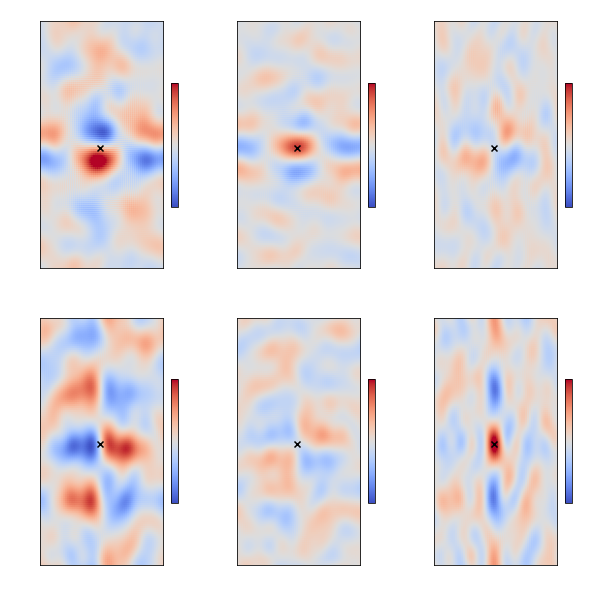

In [44]:
ML_XY_field = ML_XY.reshape(ML_state[-1][0].shape[:-1] + (obs_varN,))

fig, axs = plt.subplots(obs_varN,3, figsize=(10,5*obs_varN))
for i in range(obs_var.start, obs_var.stop):
    for j in range(3):
        
        if obs_varN == 1:
            ax = axs[j]
        elif obs_varN > 1:
            ax = axs[i-obs_var.start,j]
            
        im = ax.imshow(ML_XY_field[j,:,:,i-obs_var.start], vmin=-vlims[j][i],vmax=vlims[j][i], cmap="coolwarm")
        ax.scatter(Hx, Hy, marker="x", c="black")
        plt.colorbar(im, ax=ax, shrink=0.5)

fig.suptitle("Kalman Gain", y=0.9)

In [45]:
np.sqrt(np.sum((ML_XY_field - SL_XY)**2))

8314.5805596335

### Covariances

$\Sigma_{XY} = \mathbb{E}\left[ X  Y \right] - \mathbb{E}[X] \mathbb{E}[Y] $

and using ML-estimator for all expected values

In [46]:
ML_XY = np.zeros((np.prod(ML_state[-1][0].shape[:-1]),obs_varN))

In [47]:
X0 = ML_state[0]
Y0 = ML_state[0][obs_var,obs_idxs[0][0],obs_idxs[0][1]]

ML_XY += (1/Nes[0]*(
            X0.reshape(-1,Nes[0]) 
            @ Y0.T)
         ).reshape(X0.shape[:-1] + (obs_varN,)).repeat(2**(numLevels-1),1).repeat(2**(numLevels-1),2).reshape(-1,obs_varN)

In [48]:
for l_idx in range(1,len(ls)):

    X0 = ML_state[l_idx][0]
    X1 = ML_state[l_idx][1].repeat(2,1).repeat(2,2)

    Y0 = ML_state[l_idx][0][obs_var,obs_idxs[l_idx][0][0],obs_idxs[l_idx][0][1]]
    Y1 = ML_state[l_idx][1][obs_var,obs_idxs[l_idx][1][0],obs_idxs[l_idx][1][1]]

    ML_XY += ( ( 1/Nes[l_idx]*(
                  X0.reshape(-1,Nes[l_idx]) @ Y0.T) 
                 - 1/Nes[l_idx]*(
                  X1.reshape(-1,Nes[l_idx]) @ Y1.T) 
                )
             ).reshape(X0.shape[:-1] + (obs_varN,)).repeat(2**(numLevels-l_idx-1),1).repeat(2**(numLevels-l_idx-1),2).reshape(-1,obs_varN)


In [49]:
ML_XY = ML_XY - np.outer(Xmean.flatten(),Ymean)

Text(0.5, 0.9, 'Kalman Gain')

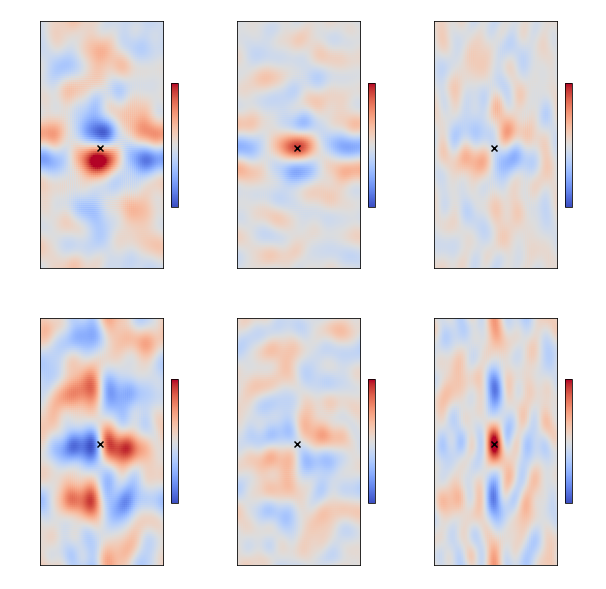

In [50]:
ML_XY_field = ML_XY.reshape(ML_state[-1][0].shape[:-1] + (obs_varN,))

fig, axs = plt.subplots(obs_varN,3, figsize=(10,5*obs_varN))
for i in range(obs_var.start, obs_var.stop):
    for j in range(3):
        
        if obs_varN == 1:
            ax = axs[j]
        elif obs_varN > 1:
            ax = axs[i-obs_var.start,j]
            
        im = ax.imshow(ML_XY_field[j,:,:,i-obs_var.start], vmin=-vlims[j][i],vmax=vlims[j][i], cmap="coolwarm")
        ax.scatter(Hx, Hy, marker="x", c="black")
        plt.colorbar(im, ax=ax, shrink=0.5)

fig.suptitle("Kalman Gain", y=0.9)

In [51]:
np.sqrt(np.sum((ML_XY_field - SL_XY)**2))

8307.934362076836

### Covariances

adding excess variabilty

In [52]:
ML_XY = np.zeros((np.prod(ML_state[-1][0].shape[:-1]),obs_varN))

In [53]:
X0 = ML_state[0]
X0mean = np.average(X0, axis=-1)

Y0 = ML_state[0][obs_var,obs_idxs[0][0],obs_idxs[0][1]]
Y0mean = np.average(Y0, axis=-1)[:,np.newaxis]

ML_XY += (1/Nes[0]*(
            (X0-X0mean[:,:,:,np.newaxis]).reshape(-1,Nes[0]) 
            @ (Y0 - Y0mean).T)
         ).reshape(X0mean.shape + (obs_varN,)).repeat(2**(numLevels-1),1).repeat(2**(numLevels-1),2).reshape(-1,obs_varN)

In [54]:
for l_idx in range(1,len(ls)):

    X0 = ML_state[l_idx][0]
    X0mean = np.average(X0, axis=-1)[:,:,:,np.newaxis]
    X1 = ML_state[l_idx][1].repeat(2,1).repeat(2,2)
    X1mean = np.average(X1, axis=-1)[:,:,:,np.newaxis]

    Y0 = ML_state[l_idx][0][obs_var,obs_idxs[l_idx][0][0],obs_idxs[l_idx][0][1]]
    Y0mean = np.average(Y0, axis=-1)[:,np.newaxis]
    Y1 = ML_state[l_idx][1][obs_var,obs_idxs[l_idx][1][0],obs_idxs[l_idx][1][1]]
    Y1mean = np.average(Y1, axis=-1)[:,np.newaxis]

    ML_XY += ( 1/Nes[l_idx]*(
                  ((X0-X0mean)-(X1-X1mean)).reshape(-1,Nes[l_idx]) @ ((Y0-Y0mean)-(Y1-Y1mean)).T) 
              ).reshape(X0.shape[:-1] + (obs_varN,)).repeat(2**(numLevels-l_idx-1),1).repeat(2**(numLevels-l_idx-1),2).reshape(-1,obs_varN)


Text(0.5, 0.9, 'Kalman Gain')

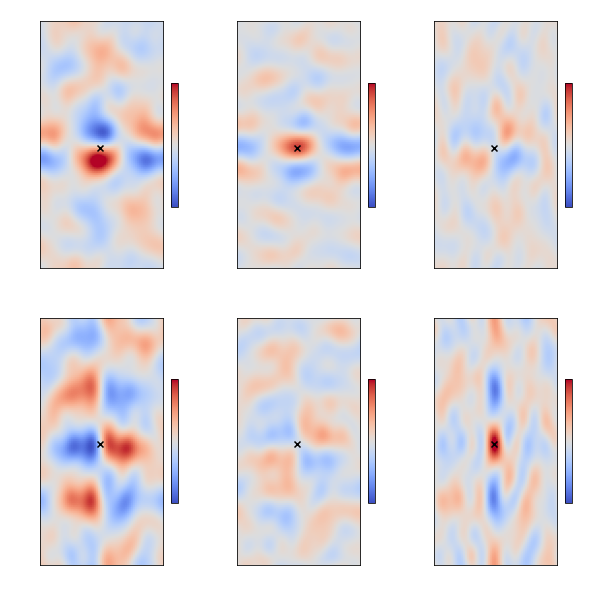

In [55]:
ML_XY_field = ML_XY.reshape(ML_state[-1][0].shape[:-1] + (obs_varN,))

fig, axs = plt.subplots(obs_varN,3, figsize=(10,5*obs_varN))
for i in range(obs_var.start, obs_var.stop):
    for j in range(3):
        
        if obs_varN == 1:
            ax = axs[j]
        elif obs_varN > 1:
            ax = axs[i-obs_var.start,j]
            
        im = ax.imshow(ML_XY_field[j,:,:,i-obs_var.start], vmin=-vlims[j][i],vmax=vlims[j][i], cmap="coolwarm")
        ax.scatter(Hx, Hy, marker="x", c="black")
        plt.colorbar(im, ax=ax, shrink=0.5)

fig.suptitle("Kalman Gain", y=0.9)

In [56]:
np.sqrt(np.sum((ML_XY_field - SL_XY)**2))

8215.411369688614